In [3]:
import os
import json
import math
import random
from typing import List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2


# 1. HYPERPARAMETERS & CONFIGURATION


## --- Data Paths ---


In [4]:
LANDMARK_FILE = '/kaggle/input/landmarks-553-for-300-classes/Landmarks_300_553_3D.npz'
SPLIT_FILE = '/kaggle/input/wlasl2000-resized/wlasl-complete/nslt_300.json'


## --- Reproducibility ---


In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


## --- Model Hyperparameters ---


In [6]:
INPUT_SIZE = 553 * 3
NUM_CLASSES = 300
LSTM_HIDDEN_SIZE = 256
LSTM_NUM_LAYERS = 2
MODEL_DROPOUT = 0.5


## --- Training Hyperparameters ---


In [ ]:
EPOCHS = 200
BATCH_SIZE = 32
BASE_LR = 3e-4
GRADIENT_CLIP_NORM = 1.0
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.1
MIXUP_ALPHA = 0.4
WARMUP_EPOCHS = max(5, int(0.1 * EPOCHS))

## --- System Configuration ---


In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = DEVICE.type == 'cuda'
print(f"Using device: {DEVICE}, AMP: {USE_AMP}")

Using device: cuda, AMP: True


# 2. PREPROCESSOR, DATASET, AND MODEL CLASSES


In [9]:
class LandmarkPreprocessor:
    def __init__(self, augment=True):
        self.augment = augment
        self.POSE_IDXS = list(range(0, 33)); self.FACE_IDXS = list(range(33, 501)); self.LEFT_HAND_IDXS = list(range(511, 532)); self.RIGHT_HAND_IDXS = list(range(532, 552))
    def normalize_frame(self, frame_landmarks: np.ndarray) -> np.ndarray:
        normalized_frame = np.copy(frame_landmarks); pose_landmarks = frame_landmarks[self.POSE_IDXS]
        if np.sum(np.abs(pose_landmarks)) > 0:
            nose, l_s, r_s, l_e = pose_landmarks[0, :2], pose_landmarks[11, :2], pose_landmarks[12, :2], pose_landmarks[2, :2]; dist = np.linalg.norm(l_s - r_s)
            if dist > 1e-4:
                hu = dist / 2.0; bw, bh, bx, by = 6 * hu, 7 * hu, nose[0] - 3 * hu, l_e[1] - 0.5 * hu; pf_idxs = self.POSE_IDXS + self.FACE_IDXS
                if bw > 0 and bh > 0:
                    normalized_frame[pf_idxs, 0] = (frame_landmarks[pf_idxs, 0] - bx) / bw - 0.5; normalized_frame[pf_idxs, 1] = (frame_landmarks[pf_idxs, 1] - by) / bh - 0.5
        for h_idxs in [self.LEFT_HAND_IDXS, self.RIGHT_HAND_IDXS]:
            hand_landmarks = frame_landmarks[h_idxs]
            if np.sum(np.abs(hand_landmarks)) > 0:
                xs, ys = hand_landmarks[:, 0], hand_landmarks[:, 1]
                if len(xs) > 0 and np.max(xs) != np.min(xs):
                    xmin, xmax, ymin, ymax = np.min(xs), np.max(xs), np.min(ys), np.max(ys); box_size = max(xmax - xmin, ymax - ymin, 1e-4)
                    normalized_frame[h_idxs, 0] = (hand_landmarks[:, 0] - xmin) / box_size - 0.5; normalized_frame[h_idxs, 1] = (hand_landmarks[:, 1] - ymin) / box_size - 0.5
        return normalized_frame
    def augment_sequence(self, sequence: np.ndarray) -> np.ndarray:
        angle = random.uniform(-13, 13); rad = np.deg2rad(angle); cos, sin = np.cos(rad), np.sin(rad); rot_matrix = np.array([[cos, -sin], [sin, cos]])
        points = sequence[:, :, :2].reshape(-1, 2); rotated_points = points @ rot_matrix.T; sequence[:, :, :2] = rotated_points.reshape(sequence.shape[0], -1, 2)
        noise = np.random.normal(0, 0.005, sequence.shape).astype(np.float32); sequence += noise
        return sequence
    def __call__(self, landmark_sequence: np.ndarray, is_train: bool):
        landmark_sequence[np.isnan(landmark_sequence)] = 0; normalized_sequence = np.array([self.normalize_frame(frame) for frame in landmark_sequence])
        if is_train and self.augment: normalized_sequence = self.augment_sequence(normalized_sequence)
        return normalized_sequence

## Dataset Class

In [10]:
class WLASLLandmarkDataset(Dataset):
    def __init__(self, landmark_path, split_file_path, split='train'):
        self.split = split; self.preprocessor = LandmarkPreprocessor()
        landmarks_data = dict(np.load(landmark_path, allow_pickle=True))
        with open(split_file_path, 'r') as f: split_data = json.load(f)
        split_dict = split_data.get('root', split_data)
        self.samples = []
        for video_id, info in split_dict.items():
            if info.get('subset') == self.split:
                if video_id in landmarks_data:
                    self.samples.append({"landmarks": landmarks_data[video_id], "label": int(info['action'][0])})
        print(f"✅ Created '{self.split}' split with {len(self.samples)} samples.")
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        sample = self.samples[idx]; landmark_sequence, class_index = sample["landmarks"], sample["label"]
        processed_sequence = self.preprocessor(landmark_sequence, is_train=(self.split == 'train'))
        flattened_landmarks = processed_sequence.reshape(processed_sequence.shape[0], -1)
        return torch.tensor(flattened_landmarks, dtype=torch.float32), torch.tensor(class_index, dtype=torch.long)

def variable_length_collate_fn(batch):
    sequences, labels = zip(*batch); lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    return padded_sequences, torch.tensor(labels, dtype=torch.long), lengths


## Model Architecture

In [1]:

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__(); self.attn_net = nn.Sequential(nn.Linear(hidden_size, hidden_size // 2), nn.Tanh(), nn.Linear(hidden_size // 2, 1))
    def forward(self, lstm_output):
        attn_scores = self.attn_net(lstm_output).squeeze(-1); attn_weights = F.softmax(attn_scores, dim=1).unsqueeze(1)
        context_vector = torch.bmm(attn_weights, lstm_output).squeeze(1); return context_vector, attn_weights

class LandmarkBiLSTMAttentionModel(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size, num_layers, dropout_rate):
        super(LandmarkBiLSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.2 if num_layers > 1 else 0)
        self.attention = Attention(hidden_size * 2)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    def forward(self, x, lengths):
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (h_n, _) = self.lstm(packed_input)
        lstm_output, _ = pad_packed_sequence(packed_output, batch_first=True)
        context_vector, _ = self.attention(lstm_output)
        x = self.layer_norm(context_vector)
        return self.fc(self.dropout(x))

NameError: name 'nn' is not defined

# 3. TRAINING EXECUTION


## --- Data Loading ---


In [12]:
print("\n--- Initializing DataLoaders ---")
train_dataset = WLASLLandmarkDataset(LANDMARK_FILE, SPLIT_FILE, split='train')
val_dataset = WLASLLandmarkDataset(LANDMARK_FILE, SPLIT_FILE, split='val')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=variable_length_collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=variable_length_collate_fn, num_workers=4, pin_memory=True)



--- Initializing DataLoaders ---
✅ Created 'train' split with 3549 samples.
✅ Created 'val' split with 901 samples.


## --- Class Weights ---


In [13]:
train_labels = [int(sample['label']) for sample in train_dataset.samples]
class_weights = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print("Class weights calculated.")


Class weights calculated.


## --- Model, Optimizer, Scheduler, Scaler ---


In [14]:
print("\n--- Initializing Model ---")
model = LandmarkBiLSTMAttentionModel(INPUT_SIZE, NUM_CLASSES, LSTM_HIDDEN_SIZE, LSTM_NUM_LAYERS, MODEL_DROPOUT).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)



--- Initializing Model ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_36/3019509604.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


# --- Training Loop ---


In [15]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = [], [], [], []
best_accuracy = 0.0



In [16]:
print("\n--- Starting Training ---")
for epoch in range(EPOCHS):
    if epoch < WARMUP_EPOCHS:
        tiny_lr = BASE_LR * 0.01; current_lr = tiny_lr + (BASE_LR - tiny_lr) * ((epoch + 1) / WARMUP_EPOCHS)
        dropout_p, label_smoothing, current_weight_decay = 0.1, 0.0, 1e-6
    else:
        current_lr, dropout_p, label_smoothing, current_weight_decay = BASE_LR, MODEL_DROPOUT, LABEL_SMOOTHING, WEIGHT_DECAY
    for pg in optimizer.param_groups: pg['lr'], pg['weight_decay'] = current_lr, current_weight_decay
    model.dropout.p = dropout_p
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=label_smoothing)

    model.train(); running_loss, train_correct, train_total = 0.0, 0.0, 0
    for landmarks, labels, lengths in train_loader:
        landmarks, labels, lengths = landmarks.to(DEVICE), labels.to(DEVICE), lengths.to(DEVICE)
        batch_size = landmarks.size(0)
        if batch_size > 1 and MIXUP_ALPHA > 0:
            lam = np.random.beta(MIXUP_ALPHA, MIXUP_ALPHA)
            shuffle_indices = torch.randperm(batch_size, device=DEVICE)
            shuffled_landmarks, shuffled_labels = landmarks[shuffle_indices], labels[shuffle_indices]
            mixed_landmarks = lam * landmarks + (1 - lam) * shuffled_landmarks
        else:
            lam, mixed_landmarks, shuffled_labels = 1.0, landmarks, labels
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(mixed_landmarks, lengths)
            loss = lam * criterion(outputs, labels) + (1 - lam) * criterion(outputs, shuffled_labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_NORM)
        scaler.step(optimizer); scaler.update()
        running_loss += loss.item() * float(batch_size); _, predicted = torch.max(outputs.detach(), 1)
        train_total += labels.size(0); train_correct += (lam * (predicted == labels).sum().item() + (1 - lam) * (predicted == shuffled_labels).sum().item())
    avg_train_loss, train_accuracy = running_loss / train_total, 100.0 * train_correct / train_total

    model.eval(); val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for landmarks, labels, lengths in val_loader:
            landmarks, labels, lengths = landmarks.to(DEVICE), labels.to(DEVICE), lengths.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=USE_AMP):
                outputs = model(landmarks, lengths); loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0); _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0); val_correct += (predicted == labels).sum().item()
    avg_val_loss, val_accuracy = val_loss / max(1, val_total), 100.0 * val_correct / max(1, val_total)
    
    scheduler.step(avg_val_loss)
    train_loss_history.append(avg_train_loss); train_acc_history.append(train_accuracy); val_loss_history.append(avg_val_loss); val_acc_history.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | lr={current_lr:.6g} | Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.2f}% | Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.2f}%")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_landmark_attention_model_300.pth'); print(f"✅ New best model saved: {best_accuracy:.2f}%")

print("\n✨ Training finished!")


--- Starting Training ---


/tmp/ipykernel_36/3971316330.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipykernel_36/3971316330.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


Epoch 1/200 | lr=1.785e-05 | Train Loss=5.8477, Train Acc=0.37% | Val Loss=5.7257, Val Acc=0.33%
✅ New best model saved: 0.33%
Epoch 2/200 | lr=3.27e-05 | Train Loss=5.7699, Train Acc=0.37% | Val Loss=5.6696, Val Acc=0.33%
Epoch 3/200 | lr=4.755e-05 | Train Loss=5.7151, Train Acc=0.48% | Val Loss=5.5609, Val Acc=1.44%
✅ New best model saved: 1.44%
Epoch 4/200 | lr=6.24e-05 | Train Loss=5.5107, Train Acc=1.24% | Val Loss=5.1627, Val Acc=3.22%
✅ New best model saved: 3.22%
Epoch 5/200 | lr=7.725e-05 | Train Loss=5.1462, Train Acc=3.79% | Val Loss=4.7019, Val Acc=7.77%
✅ New best model saved: 7.77%
Epoch 6/200 | lr=9.21e-05 | Train Loss=4.8206, Train Acc=7.13% | Val Loss=4.3923, Val Acc=13.54%
✅ New best model saved: 13.54%
Epoch 7/200 | lr=0.00010695 | Train Loss=4.5460, Train Acc=10.06% | Val Loss=4.1346, Val Acc=18.65%
✅ New best model saved: 18.65%
Epoch 8/200 | lr=0.0001218 | Train Loss=4.2976, Train Acc=14.87% | Val Loss=3.8116, Val Acc=23.75%
✅ New best model saved: 23.75%
Epoch 9/


--- Plotting Training History with Bold Colors ---


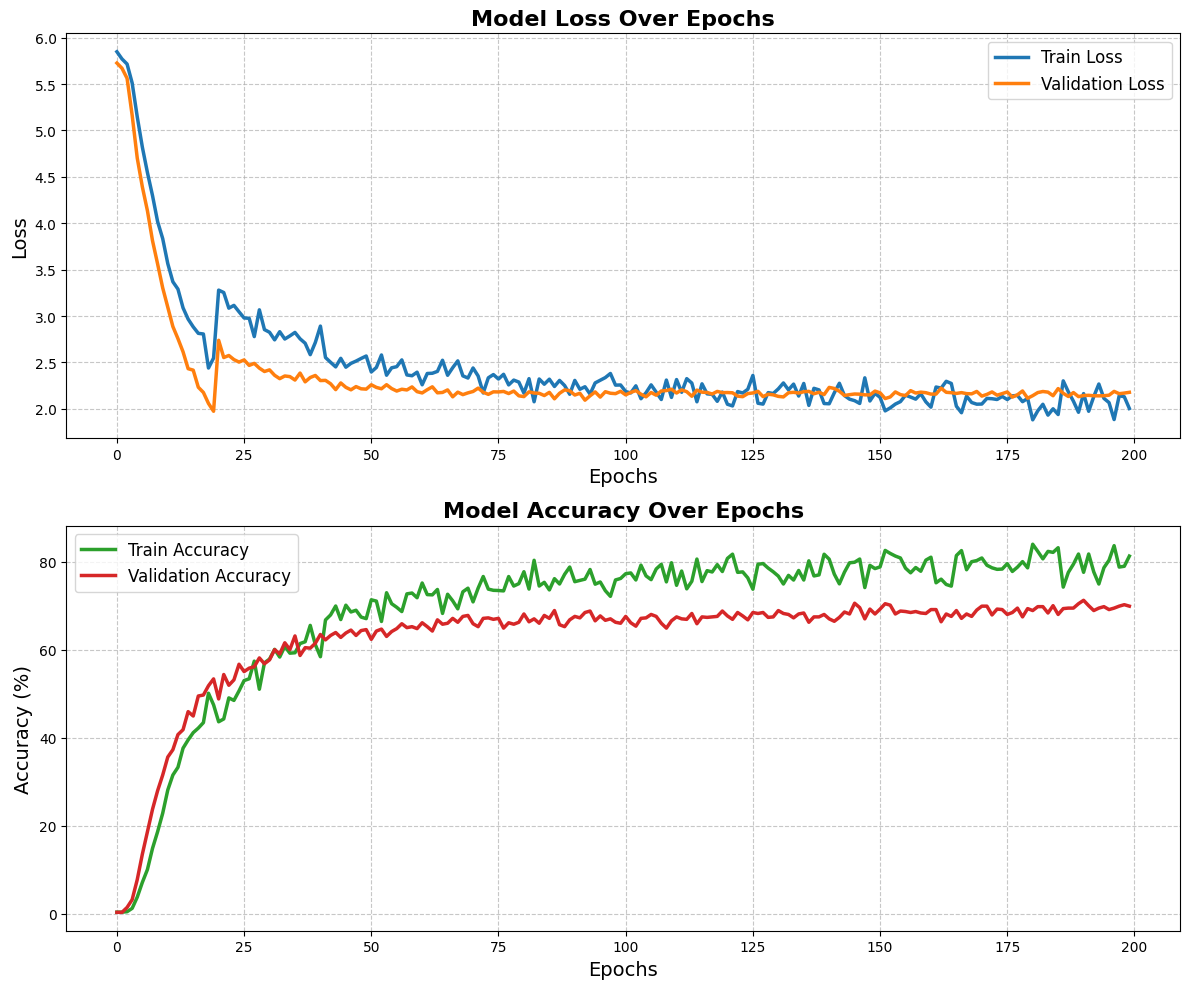

In [17]:
import matplotlib.pyplot as plt

print("\n--- Plotting Training History with Bold Colors ---")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Loss plot
ax1.plot(train_loss_history, label='Train Loss', color='#1f77b4', linewidth=2.5)  # Deep blue
ax1.plot(val_loss_history, label='Validation Loss', color='#ff7f0e', linewidth=2.5)  # Orange
ax1.set_title('Model Loss Over Epochs', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Accuracy plot
ax2.plot(train_acc_history, label='Train Accuracy', color='#2ca02c', linewidth=2.5)  # Green
ax2.plot(val_acc_history, label='Validation Accuracy', color='#d62728', linewidth=2.5)  # Red
ax2.set_title('Model Accuracy Over Epochs', fontsize=16, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [2]:
# Paths (update with your actual files)
LANDMARK_PATH = "/kaggle/input/landmarks-553-for-300-classes/Landmarks_300_553_3D.npz"   # your big NPZ with 300 classes
SPLIT_FILE_PATH = "/kaggle/input/wlasl2000-resized/wlasl-complete/nslt_300.json" # JSON split file

# Create test dataset
test_dataset = WLASLLandmarkDataset(
    landmark_path=LANDMARK_PATH,
    split_file_path=SPLIT_FILE_PATH,
    split='test'
)


NameError: name 'WLASLLandmarkDataset' is not defined

In [19]:
from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=32,   # adjust depending on GPU memory
    shuffle=False,
    collate_fn=variable_length_collate_fn,
    num_workers=2,   # increase if running locally, set 0 for Kaggle
    pin_memory=True
)


In [20]:
# Input size = 553 landmarks × 3 coords (x,y,z)
INPUT_SIZE = 553 * 3
HIDDEN_SIZE = 256
NUM_LAYERS = 2
DROPOUT_RATE = 0.3
NUM_CLASSES = 300

model = LandmarkBiLSTMAttentionModel(
    input_size=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout_rate=DROPOUT_RATE
).to(DEVICE)

model.load_state_dict(torch.load("/kaggle/working/best_landmark_attention_model_300.pth", map_location=DEVICE))
model.eval()


LandmarkBiLSTMAttentionModel(
  (lstm): LSTM(1659, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): Attention(
    (attn_net): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=300, bias=True)
)

In [21]:
import torch.nn.functional as F

test_loss, test_correct, test_total = 0.0, 0, 0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for landmarks, labels, lengths in test_loader:
        landmarks, labels, lengths = landmarks.to(DEVICE), labels.to(DEVICE), lengths.to(DEVICE)
        outputs = model(landmarks, lengths)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / max(1, test_total)
test_accuracy = 100.0 * test_correct / max(1, test_total)

print(f"\n📊 Test Loss={avg_test_loss:.4f}, Test Accuracy={test_accuracy:.2f}%")



📊 Test Loss=1.7655, Test Accuracy=63.77%
